In [202]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"    
os.environ["KERAS_BACKEND"] = "tensorflow"
#os.environ["CUDA_VISIBLE_DEVICES"] = str(2)

import uproot
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import networkx as nx
#from itertools import combinations
#from hausdorff import hausdorff_distance
import copy
import math
import keras
import glob
import sys
import datetime
import keras
import numba
import skimage

In [203]:
%matplotlib inline

In [204]:
sys.path += ["../test"]

In [205]:
import training

In [212]:
image_size = 256
block_size = 8
nblock = int((image_size/8))

In [207]:
@numba.njit
def to_list(pp_image, pt_cut=0.0):
    bins = [
        np.linspace(-5,5,image_size + 1),
        np.linspace(-5,5,image_size + 1)
    ]
    
    icand = 0
    cands = np.zeros((image_size*image_size,3), dtype=np.float32)
    for ix in range(pp_image.shape[0]):
        for iy in range(pp_image.shape[1]):
            p = pp_image[ix, iy]
            if p > pt_cut:
                eta = bins[0][ix]
                phi = bins[1][iy]
                cands[icand, 0] = p
                cands[icand, 1] = eta
                cands[icand, 2] = phi
                icand += 1
    return cands[:icand]

In [248]:
Xs_cluster = []
Xs_track = []
ys_cand = []
maxclusters = -1
maxtracks = -1
maxcands = -1
for fn in glob.glob("../data/NuGun/step3_AOD_14.root"):
    try:
        fi = uproot.open(fn)
        tree = fi.get("pftree")
    except Exception as e:
        print("Could not open file {0}".format(fn))
        continue
    data = tree.arrays(tree.keys())
    data = {str(k, 'ascii'): v for k, v in data.items()}
    for iev in range(len(tree)):
        pt = data["pfcands_pt"][iev]
        eta = data["pfcands_eta"][iev]
        phi = data["pfcands_phi"][iev]
        charge = data["pfcands_charge"][iev]

        Xs_cluster += [np.stack([
            data["clusters_energy"][iev][:maxclusters],
            data["clusters_eta"][iev][:maxclusters],
            data["clusters_phi"][iev][:maxclusters],
            ], axis=1)
        ]
        Xs_track += [np.stack([
            np.abs(1.0/data["tracks_qoverp"][iev][:maxtracks]),
            data["tracks_inner_eta"][iev][:maxtracks],
            data["tracks_inner_phi"][iev][:maxtracks],
            data["tracks_outer_eta"][iev][:maxtracks],
            data["tracks_outer_phi"][iev][:maxtracks],
            ], axis=1)
        ]
        ys_cand += [np.stack([
            pt[:maxcands],
            eta[:maxcands],
            phi[:maxcands],
            charge[:maxcands]
            ], axis=1)
        ]

In [421]:
model = keras.models.load_model("../out/2019-09-24_17-28-32/model.h5") 

In [422]:
len(Xs_cluster)

500

In [423]:
all_clusters = np.vstack(Xs_cluster)
all_tracks = np.vstack(Xs_track)

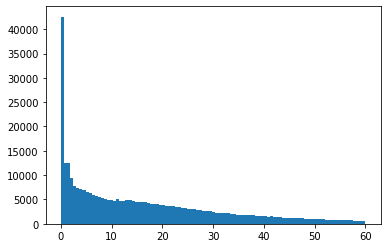

In [424]:
plt.hist(all_clusters[:, 0], bins=np.linspace(0,60,100));

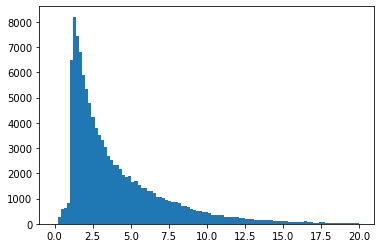

In [425]:
plt.hist(all_tracks[:, 0], bins=np.linspace(0,20,100));

In [441]:
cands_true = []
cands_ml = []
for i in range(len(Xs_cluster)):
    img_in, img_out = training.to_image(i, Xs_cluster, Xs_track, ys_cand, image_size)
    
    bls = skimage.util.view_as_blocks(img_in, (8, 8, 3))[:, :, 0, :, :, :]
    bls = bls.reshape(nblock*nblock, 8, 8, 3)

    pred = model.predict(bls, batch_size=100)
    
    bls_out = pred.reshape((nblock, nblock, 8, 8)).reshape((image_size, image_size))
    bls_out[bls_out<0.2] = 0
    
    cands_ml += [np.stack(sorted(to_list(bls_out), key=lambda x: x[0], reverse=True))]
    cands_true += [np.stack(sorted(to_list(img_out), key=lambda x: x[0], reverse=True))]
    
cands_true_all = np.vstack(cands_true)
cands_ml_all = np.vstack(cands_ml)

In [442]:
num_cands_ml = [len(x) for x in cands_ml]
num_cands_true = [len(x) for x in cands_true]

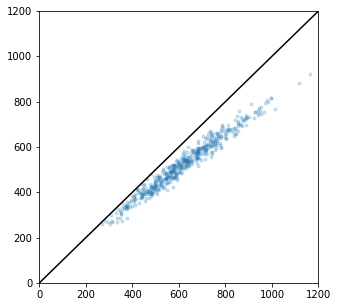

In [443]:
plt.figure(figsize=(5,5))
plt.xlim(0,1200)
plt.ylim(0,1200)
plt.scatter(num_cands_true, num_cands_ml, marker=".", alpha=0.2, label="train")
plt.plot([0,1200], [0,1200], color="black")

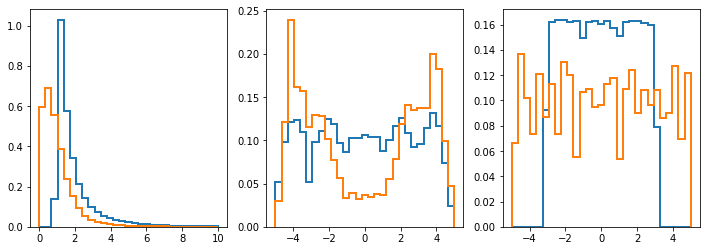

In [444]:
plt.figure(figsize=(3*4,4))

plt.subplot(1,3,1)
bins = np.linspace(0,10,30)
plt.hist([c[0] for c in cands_true_all], bins=bins, histtype="step", lw=2, density=1);
plt.hist([c[0] for c in cands_ml_all], bins=bins, histtype="step", lw=2, density=1);

plt.subplot(1,3,2)
bins = np.linspace(-5,5,30)
plt.hist([c[1] for c in cands_true_all], bins=bins, histtype="step", lw=2, density=1);
plt.hist([c[1] for c in cands_ml_all], bins=bins, histtype="step", lw=2, density=1);

plt.subplot(1,3,3)
bins = np.linspace(-5,5,30)
plt.hist([c[2] for c in cands_true_all], bins=bins, histtype="step", lw=2, density=1);
plt.hist([c[2] for c in cands_ml_all], bins=bins, histtype="step", lw=2, density=1);

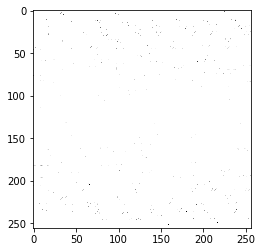

In [445]:
plt.imshow(bls_out, cmap="binary", vmin=0, vmax=5)

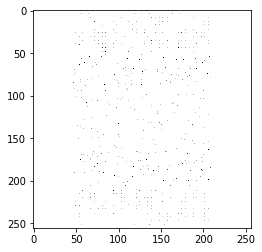

In [446]:
plt.imshow(img_out, cmap="binary", vmin=0, vmax=5)

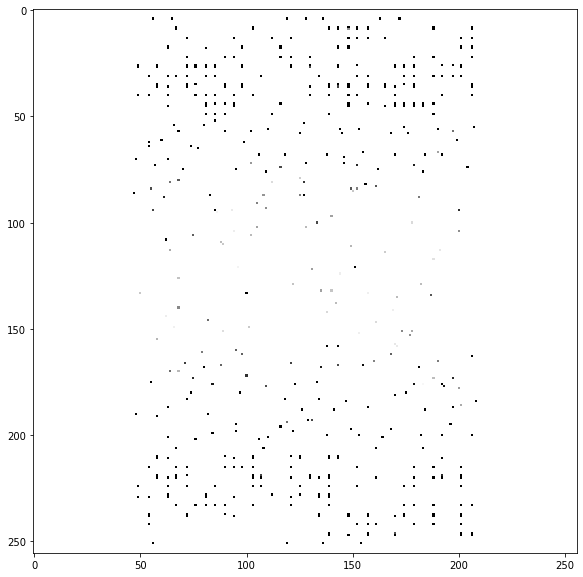

In [447]:
plt.figure(figsize=(10,10))
plt.imshow(img_in[:, :, 0], cmap="binary", vmin=0, vmax=5, interpolation=None)

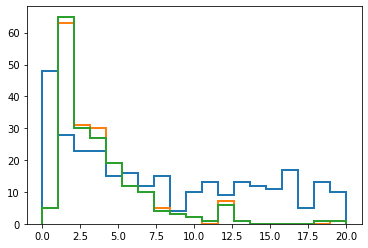

In [448]:
bins = np.linspace(0, 20, 20)

p = img_in[:, :, 0]
plt.hist(p[p>0], bins=bins, histtype="step", lw=2);

p = img_in[:, :, 1]
plt.hist(p[p>0], bins=bins, histtype="step", lw=2);

p = img_in[:, :, 2]
plt.hist(p[p>0], bins=bins, histtype="step", lw=2);

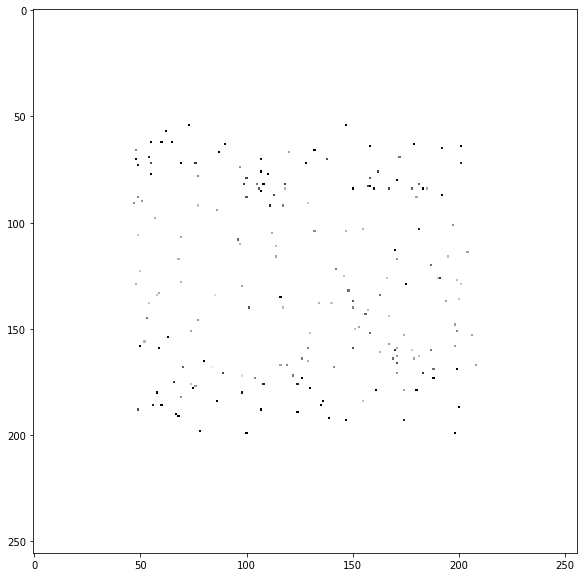

In [449]:
plt.figure(figsize=(10,10))
plt.imshow(img_in[:, :, 1], cmap="binary", vmin=0, vmax=5, interpolation=None)

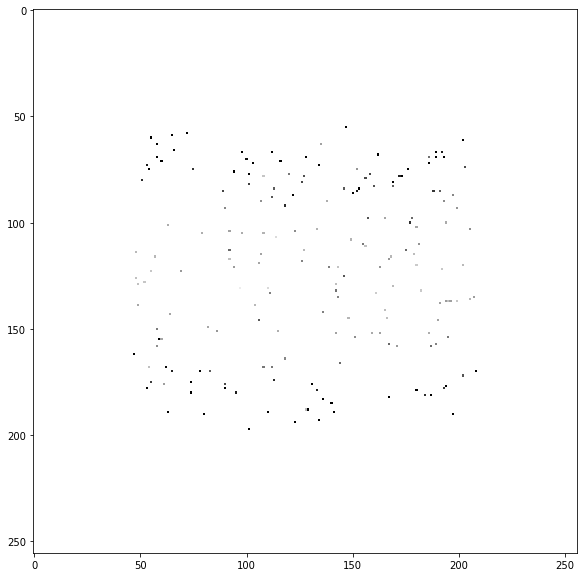

In [450]:
plt.figure(figsize=(10,10))
plt.imshow(img_in[:, :, 2], cmap="binary", vmin=0, vmax=5, interpolation=None)

In [436]:
fi = open("../data/TTbar/step3_AOD_2.npz", "rb")

In [437]:
data = np.load(fi)

In [438]:
imgs_in = data["data_images_in"]
imgs_out = data["data_images_out"]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

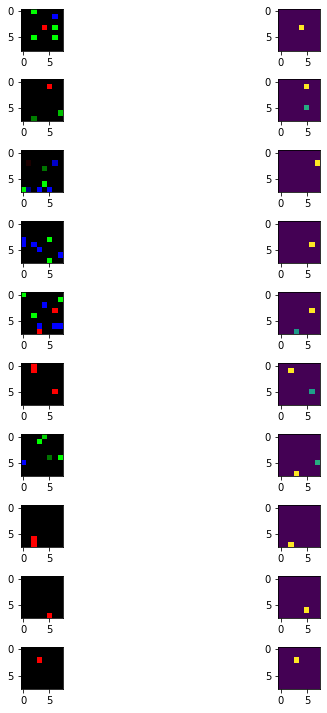

In [457]:
iev = 1023
plt.figure(figsize=(10,10))
ipl = 1

for i in range(iev,iev+10):
    plt.subplot(10, 2, ipl)
    plt.imshow(imgs_in[i])
    
    ipl += 1
    plt.subplot(10, 2, ipl)
    plt.imshow(imgs_out[i, :, :, 0])
    
    ipl += 1

plt.tight_layout()

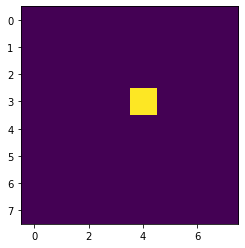

In [452]:
plt.imshow(imgs_out[iev, :, :, 0])